# Conformer Generation Pipeline

## **Step 1: Input Smile and Reference Conformer**

In [1]:
import time

# Capture the start time
start_time: float = time.time()

In [2]:
import sys

# Add a folder to Python's import path
sys.path.append('/app')

In [3]:
from atk_conformer_generation_pipeline.utils import *
from atk_conformer_generation_pipeline.variables import *
import os
import glob
import re
import subprocess
from pyscf import gto
from pyscf.geomopt import geometric_solver
from gpu4pyscf.dft import rks
from pyscf.hessian import thermo
from termcolor import colored

In [4]:
import os
# Specify which GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["OMP_NUM_THREADS"] = "25"
os.environ["MKL_NUM_THREADS"] = "25"
os.environ["OPENBLAS_NUM_THREADS"] = "25"

In [5]:
#Change the dir to /work
os.chdir("/work")
!pwd

/work


**Change the below variables accordingly**

In [6]:
#inp_smiles: str="O=C(O)/C=C/C(=O)O"
#dielectric_value: float=46.826
#output_dir: str="SMILE2"
#pdb_file: str="traj_cent_sampled_skip50.pdb"
#num_conf_rdkit: int = 200     # Number of conformers to be generated
#E_avg_proton: float=-274.8838384  # E_H (solv) in kcal/mol
#pKa_EXP: float=10.04 # Experimental pKa

In [7]:
os.makedirs(output_dir, exist_ok=True)
os.chdir(output_dir)

In [8]:
!pwd

/work/SMILE2


In [9]:
import sys
sys.setrecursionlimit(10000)
# set the maximum depth of the Python interpreter stack. This stack depth is crucial for recursive function calls, 
# as it limits how deep the recursion can go before causing a RecursionError.

**Importing the necessary libraries**

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import shutil
import time
import os
import re
import shutil
import pandas as pd
import numpy as np
from numpy import loadtxt
import csv
from typing import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.gridspec import GridSpec

In [11]:
%%time

### Remove all files and directories created in the previous execution to avoid any confusion

file_and_dir_to_remove: List[str]=[init_conf_xyz,opt_conf_SMILES_file,similarity_output_csv,
feasible_geometries_csv,infeasible_geometries_csv,feasible_geometries_xyz,infeasible_geometries_xyz,pairwise_RMSDs_dat,
pairwise_RMSDs_csv,cluster_reps_csv,cluster_reps_xyz,cluster_rep_prefix,cluster_reps_dir,clusters_RMSD_stats_csv,clusters_energy_stats_csv,
opt_cluster_reps_csv]

remove_paths(file_and_dir_to_remove)

File initial_generated_conformers.sdf has been removed.
File optimized_generated_conformers.smi has been removed.
File tanimoto_similarity.csv has been removed.
File feasible_geom_energies.csv has been removed.
File infeasible_geometries.csv has been removed.
The path feasible_geometries.xyz does not exist.
The path infeasible_geometries.xyz does not exist.
File rmsd_matrix-mx_flags.dat has been removed.
File pairwise_RMSDs.csv has been removed.
File cluster_rep_conformers.csv has been removed.
The path cluster_rep_conformers.xyz does not exist.
The path rep_of_cluster_ does not exist.
Directory cluster_rep_conformers has been removed.
The path cluster_statistics-RMSDs.csv does not exist.
The path cluster_statistics-energies.csv does not exist.
The path opt_cluster_rep_conformers.csv does not exist.
CPU times: user 0 ns, sys: 2.17 ms, total: 2.17 ms
Wall time: 1.8 ms


# Step 2: Loading TD Conformers 

In [12]:
sdf_file = "conformers_TD.sdf"

# Load all conformers from the SDF file
supplier = Chem.SDMolSupplier(sdf_file, removeHs=False)

# Create a new molecule to hold all conformers
mol_TD = None

for i, m in enumerate(supplier):
    if m is None:
        print(f"[Warning] Molecule {i} could not be read. Check formatting in SDF.")
        continue

    if mol_TD is None:
        mol_TD = Chem.Mol(m)
        mol_TD.RemoveAllConformers()  # start with clean conformer list

    # Add conformer with unique ID
    conf = m.GetConformer()
    conf.SetId(i)
    mol_TD.AddConformer(conf, assignId=True)

#save_conformers_to_sdf(mol_TD, "conformers_TD.sdf") 

### Generating Conformers using RDKit

In [14]:
%%time

import time
import sys


mol_rdkit: Chem.Mol= generate_conformers(inp_smiles, num_conf_rdkit)  # Call the function to generate conformers
save_conformers_to_sdf(mol_rdkit, "conformers_RDKit.sdf")       # Save conformers to SDF file

CPU times: user 268 ms, sys: 3.68 ms, total: 272 ms
Wall time: 69.5 ms


In [15]:
def simple_combine_conformers(mol1, mol2):
    """Simple conformer combination"""
    
    combined_mol = Chem.Mol(mol1)
    combined_mol.RemoveAllConformers()
    
    # Add all conformers from both molecules
    for i in range(mol1.GetNumConformers()):
        conf = mol1.GetConformer(i)
        combined_mol.AddConformer(conf, assignId=True)
    
    for i in range(mol2.GetNumConformers()):
        conf = mol2.GetConformer(i)
        combined_mol.AddConformer(conf, assignId=True)
    
    return combined_mol

# Usage
mol = simple_combine_conformers(mol_TD, mol_rdkit)
save_conformers_to_sdf(mol, init_conf_sdf)

In [16]:
# Find the number of atoms in the molecule
num_atoms_generated_conf: int = mol.GetNumAtoms()

# Step 3: Optimizing Conformers

In [17]:
%%time
### Optimize the generated conformers and save the optimized coordinates
opt_mol, conformer_energies = mmff_optimize_conformers(mol)     # Call the function to optimize conformers
save_conformers_to_sdf(opt_mol,opt_conf_sdf)
#print(conformer_energies)

num_opt_conf: int= opt_mol.GetNumConformers()

### Save the energies of optimized to a CSV file
conformer_energies_items : List[Tuple[int, float]] = list(conformer_energies.items())
energy_DF: pd.DataFrame = pd.DataFrame(conformer_energies_items, columns=['conformer_id', 'energy_in_kcalpermol'])
energy_DF.to_csv(opt_conf_energy_csv, index=False)

CPU times: user 677 ms, sys: 4.88 ms, total: 682 ms
Wall time: 680 ms


In [18]:
%%time

### Convert the 3D gometries of conformers into SMILES and save them
convert_conformers_to_smiles(opt_conf_sdf,opt_conf_SMILES_file)

CPU times: user 41.3 ms, sys: 100 µs, total: 41.4 ms
Wall time: 40.5 ms


In [19]:
### Process optimized conformers to calculate Tanimoto similarity and separate feasible and infeasible geometries.
infeasible_geom_DF, energy_DF=process_conformers(opt_conf_SMILES_file,opt_conf_sdf,feasible_geometries_sdf,infeasible_geometries_sdf,similarity_output_csv,infeasible_geometries_csv,inp_smiles,num_opt_conf,energy_DF)


In [20]:
%%time

### Calculate the numbers of conformers with feasible and infeasible geometries
num_feasible_geom: int = len(energy_DF)
num_infeasible_geom: int = len(infeasible_geom_DF)

with open("outputs.txt", 'a') as file:
    file.write(f'Number_of_feasible_geometries: {num_feasible_geom}\n')
    
print("Number of conformers with infeasible geometries:", num_infeasible_geom)
print("Number of conformers with feasible geometries:", num_feasible_geom)
print("Total number of conformers for which the geometry feasibility was checked:", num_infeasible_geom+num_feasible_geom)
#print("Total number of conformers generated:", num_conf)

Number of conformers with infeasible geometries: 0
Number of conformers with feasible geometries: 400
Total number of conformers for which the geometry feasibility was checked: 400
CPU times: user 924 µs, sys: 0 ns, total: 924 µs
Wall time: 688 µs


In [21]:
%%time

### Calculate the relative energies of conformers and write the results to a CSV file.
rel_energy_DF: pd.DataFrame=calculate_relative_energies(energy_DF,feasible_geometries_csv)


CPU times: user 5.29 ms, sys: 1.05 ms, total: 6.34 ms
Wall time: 5.69 ms


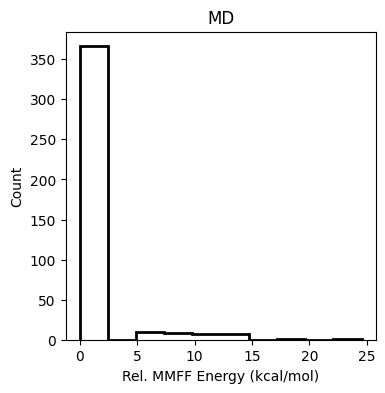

CPU times: user 382 ms, sys: 1.12 s, total: 1.5 s
Wall time: 203 ms


In [22]:
%%time

fig = plt.figure(figsize=(4, 4))

### Plot the relative energy distribution for conformers with feasible geometries
n_bins=10
plt.hist(rel_energy_DF['rel_energy_in_kcalpermol'], bins=n_bins, density=False, color='black', histtype='step', fill=False, lw=2)
#density=False: If True, the histogram is normalized so that the area under the histogram integrates to 1. If False, the histogram represents the count of occurrences in each bin.
#'bar': Traditional bar histogram (default)
plt.xlabel('Rel. MMFF Energy (kcal/mol)')
plt.ylabel('Count')
plt.title('MD')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("rel_MMFF_energies-count_histogram", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Calculating RMSD Matrix**

Using Open Babel obrms command to calculate the Root Mean Square Deviation (RMSD) between the feasiable geometries present in an SDF file

In [23]:
%%time

### Run obrms on the concatenated sdf file of conformers with feasible geometries to compute RMSD matrix
calculate_rmsd(feasible_geometries_sdf,pairwise_RMSDs_dat)

RMSD calculation completed and appended to rmsd_matrix-mx_flags.dat.
CPU times: user 3.7 ms, sys: 17.9 ms, total: 21.6 ms
Wall time: 3.23 s


In [24]:
%%time

from scipy.spatial.distance import squareform, is_valid_dm

### Read the pairwise RMSD matrix from the output of obrms; it is supposed to be a hollow, asymmetric matrix
rmsd_matrix_DF: pd.DataFrame = pd.read_csv(pairwise_RMSDs_dat, header=None, index_col=0)

### Convert the pairwise RMSD matrix into a numpy float-type 2D array
rmsd_matrix: np.ndarray = rmsd_matrix_DF.to_numpy(dtype=float)

### Round the matrix elements to two decimal places to avoid possible asymmetry in the matrix due to insignificant numerical errors
rmsd_matrix_2DP: np.ndarray  = np.round(rmsd_matrix, 2)

# Force the matrix to be symmetric
rmsd_matrix_2DP = (rmsd_matrix_2DP + rmsd_matrix_2DP.T) / 2

# Check if the matrix is symmetric
if not is_valid_dm(rmsd_matrix_2DP, throw=False):
    raise ValueError("The provided RMSD matrix is not symmetric even after rounding and forcing symmetry.")

CPU times: user 31.2 ms, sys: 12.4 ms, total: 43.5 ms
Wall time: 42.6 ms


In [26]:
%%time

### Convert the the pairwise distance matrix to its condensed form; write the pairwise RMSDs from the condensed matrix into a CSV file
from scipy.spatial.distance import squareform
condensed_matrix: np.ndarray  = squareform(rmsd_matrix_2DP)
pairwise_RMSDs_DF: pd.DataFrame = pd.DataFrame(condensed_matrix)
pairwise_RMSDs_DF.to_csv(pairwise_RMSDs_csv, header=['pairwise_RMSD'], index=False)

CPU times: user 51.6 ms, sys: 9.3 ms, total: 60.9 ms
Wall time: 59.9 ms


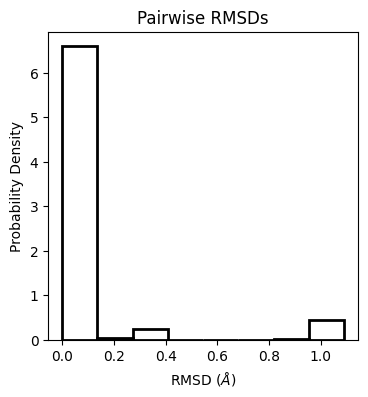

CPU times: user 596 ms, sys: 1.13 s, total: 1.72 s
Wall time: 419 ms


In [27]:
%%time

### Plot the distribution of pairwise RMSDs
fig = plt.figure(figsize=(4, 4))

### Plot the histograms
plt.hist(condensed_matrix, bins=8, density=True, color='black', fill=False, lw=2)

### Format the axes
plt.xlabel(r'RMSD ($\AA)$')
plt.ylabel('Probability Density')
plt.title('Pairwise RMSDs')
plt.grid(False)

### Show the plot
plt.show()

### Save figure
fig.savefig("pairwise_rmsd_distribution-PD.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## **Step 4: Hierarchical Cluster**

Clustering the generated conformers into 20 clusters using hierarchical clustering with `ward` linkage method. 

In [28]:
%%time

### Perform hierarchical clustering with 'ward' linkage method on the condensed version of pairwise distance matrix
import scipy.cluster.hierarchy as sch
linkage_matrix_ward: np.ndarray = sch.linkage(condensed_matrix, method='ward')

CPU times: user 6.42 ms, sys: 2.28 ms, total: 8.7 ms
Wall time: 7.84 ms


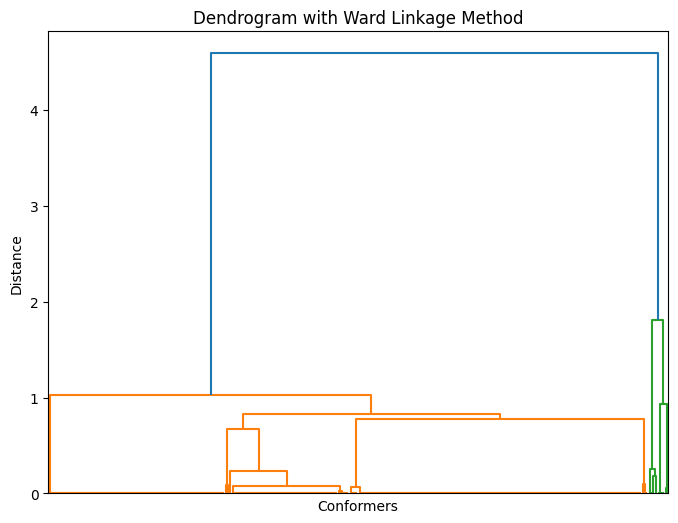

CPU times: user 169 ms, sys: 166 ms, total: 334 ms
Wall time: 149 ms


In [29]:
%%time

### A few settings to export the image of the plot
plt.style.use('default')
fig = plt.figure(figsize=(8, 6))

### Plot the dendrogram to visualize the hierarchical clustering structure
sch.dendrogram(linkage_matrix_ward, no_labels=True)
plt.title('Dendrogram with Ward Linkage Method')
plt.xlabel('Conformers')
plt.ylabel('Distance')

### Show the plot
plt.show()

### Save figure
fig.savefig("hierarchical_clustering_dendogram-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

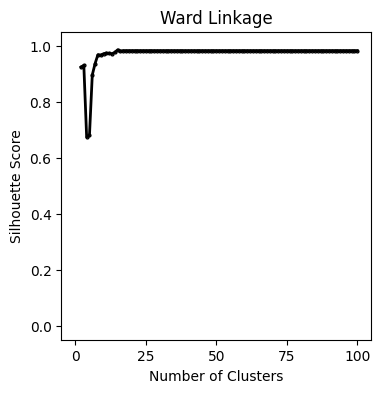

The optimal number of clusters is 15 with a silhouette score of 0.9852564102564102
CPU times: user 659 ms, sys: 176 ms, total: 835 ms
Wall time: 652 ms


In [30]:
%%time

### A few settings to export the image of the plot
# plt.style.use('~/matplotlib_templates/single_column.mplstyle')
fig = plt.figure(figsize=(4, 4))

### Determine the optimal number of clusters using silhouette score; the original pairwise RMSD matrix must be used for this
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from collections import Counter


## Calculate silhouette score for different numbers of clusters
sil_scores = []
range_n_clusters = list(range(2, 101))     # Try different numbers of clusters
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')
    cluster_counts = Counter(cluster_labels)
    # print(cluster_counts)
    
    # Check if the clustering resulted in more than one cluster
    if len(cluster_counts) > 1:
        sil_score = silhouette_score(rmsd_matrix_2DP, cluster_labels, metric='precomputed')
        sil_scores.append(sil_score)
    else:
        sil_scores.append(float('-inf'))  # Append a very low score if there's only one cluster    


## Plot the Silhouette scores
plt.plot(range_n_clusters, sil_scores, marker='o', color='black', fillstyle='none', ms=2, lw=2)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Ward Linkage")
plt.axis([-5, 105, -0.05, 1.05])
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

### Show the plot
plt.show()

### Save figure
fig.savefig("silhouette_score_vs_num_clust-ward.png", bbox_inches='tight', pad_inches=0.04, transparent = False)

## Find the optimal number of clusters based on the maximum value of silhouette score and printing it
max_sil_score = np.max(sil_scores)
optimal_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"The optimal number of clusters is {optimal_clusters} with a silhouette score of {max_sil_score}")

In [31]:
%%time

from scipy.cluster.hierarchy import linkage, fcluster

num_clusters = 5 if optimal_clusters > 5 else optimal_clusters

## For each conformer, assign the cluster label to which it belongs
cluster_labels: np.ndarray = fcluster(linkage_matrix_ward, num_clusters, criterion='maxclust')

## Create an empty dictionary to store the cluster sets
clusters: Dict[int, List[int]] = {i: [] for i in range(1, num_clusters + 1)}

## Assign each cluster label to the respective cluster set
for index, label in enumerate(cluster_labels):
    clusters[label].append(index)     # Store the indices instead of raw data
    

CPU times: user 1.36 ms, sys: 227 µs, total: 1.59 ms
Wall time: 1.59 ms


## **Step 5: Identifying Cluster Representative**

Identifying the minimum energy conformer within each cluster as its representative

In [32]:
%%time

### Identify the minimum energy conformer within each cluster as its representative

## Loop over all the cluster sets
cluster_reps_list: List[pd.DataFrame] = []

for clust_label, clust_elements in clusters.items():
    if len(clust_elements)!=0:
        clust_DF: pd.DataFrame = rel_energy_DF.loc[clust_elements]     # Extract the relative energies of the cluster elements into a dataframe
        min_energy_index: int = clust_DF['rel_energy_in_kcalpermol'].idxmin()     # Find the row index correspoding to the minimum relative energy conformer within the cluster 
        min_energy_DF: pd.DataFrame= clust_DF.loc[[min_energy_index]]     # Isolate the repesentative conformer's relative energy into a dataframe
        min_energy_DF['cluster_id'] = clust_label     # Add the 'cluster ID' information to the above dataframe
        # print(min_energy_DF)
        cluster_reps_list.append(min_energy_DF)     # Append the dataframe corresponding to each cluster representative into a list of dataframes

## Concatenate the dataframes of all cluster representatives into a single dataframe
cluster_reps_DF: pd.DataFrame = pd.concat(cluster_reps_list, ignore_index=True)

## Sort the cluster respresentatives samples by 'conformer_id' and save the sorted dataframe to a csv file
sorted_cluster_reps_DF: pd.DataFrame = cluster_reps_DF.sort_values(by='conformer_id', ascending=True)
sorted_cluster_reps_DF.to_csv(cluster_reps_csv, index=False)

CPU times: user 9.43 ms, sys: 2.26 ms, total: 11.7 ms
Wall time: 10.2 ms


In [34]:
%%time

###  Write the coordinates of cluster representative conformers to SDF files.
write_cluster_representatives(opt_conf_sdf,cluster_reps_dir,cluster_reps_sdf,sorted_cluster_reps_DF,cluster_reps_DF,cluster_rep_prefix,conf_extension)



Completed Writing the SDF files of cluster representative conformers
CPU times: user 50.4 ms, sys: 2.48 ms, total: 52.9 ms
Wall time: 52 ms


## **Step 6: Calculating the Minimum RMSD**

Calculating the min rmsd between refrence conformer and cluster representatives.

# calculating the min rmsd between refrence conformer and cluster representatives
result: float = calculate_min_rmsd(f"../{ref_confo_path}",cluster_reps_sdf)
print(f"Min RMSD 20 Clusters: {result}")

# Append the result to the text file
with open('outputs.txt', 'a') as file:
    file.write(f'Min_RMSD_20_cluster : {result}\n')

# Step 7: Geometry optimization of neutral conformers using DFT

In [ ]:
def get_atom_list(sdf_file):
    molecules = Chem.SDMolSupplier(sdf_file, removeHs=False)
    mol = next(molecules)  # Assuming you have one molecule in the SDF

    # Get the first conformer to access 3D coordinates
    conformer = mol.GetConformer()

    # Extract atomic symbols and coordinates
    atom_list = []
    for atom in mol.GetAtoms():
        pos = conformer.GetAtomPosition(atom.GetIdx())
        atom_list.append((atom.GetSymbol(), (pos.x, pos.y, pos.z)))
    return atom_list


def opti_PCM(mol, eps, xyz_filename, charge_filename, xc):
    start_time = time.time()
    # Set up the DFT calculation
    mf = rks.RKS(mol).density_fit()  # Use density fitting for efficiency
    mf.xc = xc  # Set the exchange-correlation functional

    # SCF convergence Criteria
    mf.conv_tol = 1e-8  # Energy convergence
    mf.conv_tol_grad = 3e-4  # Gradient convergence
    mf.max_cycle = 70  # Increase max iterations if needed

    # Apply the solvation model
    mf = mf.PCM()  # Initialize solvation model
    mf.grids.atom_grid = (99, 590)
    mf.with_solvent.lebedev_order = 29  # 302 Lebedev grids
    mf.with_solvent.method = 'IEF-PCM'  # Can be C-PCM, SS(V)PE, COSMO
    mf.with_solvent.eps = eps  # Set the solvent's dielectric constant

    # Perform geometry optimization
    print("Starting geometry optimization...")
    mol_opt = geometric_solver.optimize(mf, max_steps=200, xtol=1e-8, gtol=3e-4, etol=1e-8)

    # Output optimized geometry
    optimized_atoms = [(atom[0], mol_opt.atom_coords(unit='Angstrom')[i]) for i, atom in enumerate(mol_opt.atom)]

    # Ensure SCF calculation is performed after optimization
    mf_scf = rks.RKS(mol_opt).density_fit()
    mf_scf.xc = xc

    # SCF convergence Criteria
    mf_scf.conv_tol = 1e-8  # Energy convergence
    mf_scf.conv_tol_grad = 3e-4  # Gradient convergence
    mf_scf.max_cycle = 70  # Increase max iterations if needed

    # Apply the solvation model
    mf_scf = mf_scf.PCM()  # Initialize solvation model
    mf_scf.grids.atom_grid = (99, 590)
    mf_scf.with_solvent.lebedev_order = 29  # 302 Lebedev grids
    mf_scf.with_solvent.method = 'IEF-PCM'  # Can be C-PCM, SS(V)PE, COSMO
    mf_scf.with_solvent.eps = eps  # Set the solvent's dielectric constant

    #Run the scf
    mf_scf.kernel()

    #Mulliken Charge Analysis
    analysis = mf_scf.analyze()
    mulliken_charges = analysis[0][1]  # Get the Mulliken charges

    # Save captured output to file
    with open(charge_filename, "w") as charge_file:
        charge_file.write("Atom Index  Atom Symbol  Mulliken Charge\n")
        for i, charge in enumerate(mulliken_charges):
            atom_symbol = mol.atom_symbol(i)  # Get the atom symbol
            charge_file.write(f"{i+1}             {atom_symbol}        {charge:.6f}\n")


    # Extract the final energy in Hartree
    final_energy_hartree = mf_scf.e_tot

    # Convert energy from Hartree to kJ/mol
    #hartree_to_kjmol = 2625.5
    hartree_to_kcalmol=627.509
    final_energy_kcalmol = final_energy_hartree * hartree_to_kcalmol

    # Save optimized geometry to XYZ file
    with open(xyz_filename, 'w') as xyz_file:
        xyz_file.write(f"{len(optimized_atoms)}\n")
        xyz_file.write(f"Energy: {final_energy_kcalmol:.6f} kcal/mol\n")
        for symbol, coords in optimized_atoms:
            formatted_coords = ' '.join(f"{coord:.8f}" for coord in coords)
            xyz_file.write(f"{symbol} {formatted_coords}\n")

    print(f"Optimized geometry saved to '{xyz_filename}'.")

    # Print the final energy
    print(f"Final energy: {final_energy_hartree:.8f} Hartree ({final_energy_kcalmol:.6f} kcal/mol)")

    # Record the end time
    opt_time = time.time()

    # Calculate and print the total run time
    total_opt_time = opt_time - start_time
    print(f"\nOPT Time: {total_opt_time:.2f} seconds")

    print("################################################################")
    return mol_opt

In [ ]:
!export LD_LIBRARY_PATH=/opt/conda/lib:$LD_LIBRARY_PATH

In [ ]:
def extract_charge_info(sdf_path):
    """
    Extracts total formal charge from M  CHG lines in a .sdf file.
    If no M  CHG line is found, assumes formal charge = 0.
    """
    charges = {}
    with open(sdf_path) as f:
        for line in f:
            if line.startswith("M  CHG"):
                tokens = line.strip().split()
                n_entries = int(tokens[2])
                for i in range(n_entries):
                    atom_idx = int(tokens[3 + i * 2])
                    charge = int(tokens[4 + i * 2])
                    charges[atom_idx] = charge

    if charges:
        formal_charge = sum(charges.values())
    else:
        formal_charge = 0  # Default if no charge info present

    #print(f"{os.path.basename(sdf_path)}: formal charge = {formal_charge}")
    return formal_charge


In [ ]:
# Define basis sets and XC functionals to loop over
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

# Get list of charged SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))
if not sdf_files:
    print(colored(f"No SDF files found in {cluster_reps_dir}", "yellow"))


# Loop over each SDF file
for sdf_path in sdf_files:
    atom_list = get_atom_list(sdf_path)

    for basis in basis_sets:
        for xc in xc_functionals:
            start_time_sub = time.time()

            # Build molecule with given basis
            mol1 = gto.M(
                atom=atom_list,
                basis=basis,
                charge=extract_charge_info(sdf_path),
                spin=0,
                verbose=4,
            )

            # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

            # Output file names
            xyz_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.xyz')
            charge_filename = sdf_path.replace('.sdf', f'_{basis_tag}_{xc_tag}.charge')

            # Call your optimization/PCM function
            A = opti_PCM(mol1, dielectric_value, xyz_filename, charge_filename, xc)

            print(colored(f"Finished {os.path.basename(sdf_path)} | basis: {basis} | xc: {xc} in {time.time() - start_time_sub:.2f} s", "green"))


# Step 9: Geometry optimization of charged conformers using DFT

In [ ]:
def get_charge(file_path):
    """
    Reads the number of atoms directly from an SDF file.

    Args:
        file_path: The path to the SDF file.

    Returns:
        An integer representing the number of atoms, or None if the
        information cannot be extracted or the file cannot be read.
    """
    def get_num_atoms(file_path):
        try:
            with open(file_path, 'r') as f:
                # Skip the first three lines of the SDF file
                for _ in range(3):
                    f.readline()
                # Read the fourth line which contains the number of atoms
                fourth_line = f.readline().strip()
                parts = fourth_line.split()
                if parts:
                    try:
                        num_atoms = int(parts[0])
                        return num_atoms
                    except ValueError:
                        print("Error: Could not convert atom count to integer.")
                        return None
                else:
                    print("Error: Fourth line of SDF is empty.")
                    return None
        except FileNotFoundError:
            print(f"Error: File not found at {file_path}")
            return None
        except Exception as e:
            print(f"An error occurred while reading the file: {e}")
            return None
        
    #Get the charge
    A_atoms = get_num_atoms(file_path)
    #HA_atoms= get_num_atoms(file_path.replace("_treated", ""))
    clean_path = re.sub(r'(_protonated|_deprotonated)', '', file_path)
    HA_atoms = get_num_atoms(clean_path)
    formal_charge_on_HA=extract_charge_info(os.path.join(cluster_reps_dir, "rep_of_cluster_1.sdf"))
    charge=formal_charge_on_HA + (A_atoms-HA_atoms)
    print(f"Charge of {file_path}: {charge}")
    return charge

In [ ]:
# Get list of SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*.sdf")))

# Loop over each SDF file
for sdf_path in sdf_files:
    sdf_filename = os.path.basename(sdf_path)
    sdf_stem = os.path.splitext(sdf_filename)[0]  # Remove .sdf extension

    for basis in basis_sets:
        for xc in xc_functionals:
            
            # Output file names
            new_filename = f"{sdf_stem}_{basis_tag}_{xc_tag}.sdf"
            new_filepath = os.path.join(cluster_reps_dir, new_filename)
            shutil.copy(sdf_path, new_filepath)
            print("Renamed output will be:", new_filepath)


In [ ]:

# Define base paths
base_dir = f"/work/{output_dir}/cluster_rep_conformers"
treated_dir = os.path.join(base_dir, "treated")

# Run the external Python script
subprocess.run([
    "python",
    "/app/ionization_tool_with_ranking/main.py",
    base_dir
], check=True)

# Move all .sdf files from treated/ to base_dir
sdf_files = glob.glob(os.path.join(treated_dir, "*.sdf"))
for file_path in sdf_files:
    shutil.move(file_path, base_dir)

# Remove the treated directory
shutil.rmtree(treated_dir)



In [ ]:
basis_sets = ['aug-cc-pVDZ']
xc_functionals = ['M06-2X']  # Add more if needed

# Get list of treated SDF files
sdf_files = sorted(glob.glob(os.path.join(cluster_reps_dir, "*nated.sdf")))
if not sdf_files:
    print(colored(f"No SDF files found in {cluster_reps_dir}", "yellow"))


# Loop over each SDF file
for sdf_path in sdf_files:
    atom_list = get_atom_list(sdf_path)
    charge = get_charge(sdf_path)

    for basis in basis_sets:
        for xc in xc_functionals:
            start_time_sub = time.time()

            # Build molecule with given basis
            mol1 = gto.M(
                atom=atom_list,
                basis=basis,
                charge=charge,
                spin=0,
                verbose=4,
            )

            # Sanitize names for filename safety
            basis_tag = basis.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")
            xc_tag = xc.replace("(", "").replace(")", "").replace("*", "").replace("+", "").replace("/", "-").replace(" ", "")

            # Output file names
            xyz_filename = sdf_path.replace('.sdf', '.xyz')
            charge_filename = sdf_path.replace('.sdf', '.charge')

            # Call your optimization/PCM function
            A = opti_PCM(mol1, dielectric_value, xyz_filename, charge_filename, xc)

            print(colored(f"Finished {os.path.basename(sdf_path)} | basis: {basis} | xc: {xc} in {time.time() - start_time_sub:.2f} s", "green"))


# Step 10: Accumulating DFT data and Writing the CSV for pKa Calculations

In [ ]:
def create_dataframe_from_xyz_files(folder_path):
    """
    Creates a pandas DataFrame from .xyz files in a given folder,
    extracting Basis, XC, and energy.

    Args:
        folder_path (str): The path to the folder containing the .xyz files.

    Returns:
        pandas.DataFrame: A DataFrame with 'file name', 'Basis', 'XC', and 'energy' columns.
    """
    data = []

    # Updated Regex to match the filename pattern and capture Basis and XC
    # This regex is more robust to handle basis sets and XC functionals
    # that may contain hyphens, numbers, or specific characters.
    # It assumes the structure is:
    # rep_of_cluster_N_BASIS_XC_optional_treatment.xyz
    filename_pattern = re.compile(
        r"rep_of_cluster_\d+_([a-zA-Z0-9\-]+)_([a-zA-Z0-9\-]+)(?:_deprotonated|_protonated)?\.xyz"
    )

    for filename in os.listdir(folder_path):
        if filename.endswith(".xyz"):
            match = filename_pattern.match(filename)
            if match:
                basis = match.group(1)
                xc = match.group(2)

                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r') as f:
                        f.readline()  # Skip the first line (number of atoms)
                        energy_line = f.readline().strip()

                        energy = None
                        try:
                            energy = float(energy_line)
                        except ValueError:
                            energy_match = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", energy_line)
                            if energy_match:
                                energy = float(energy_match.group(0))
                            else:
                                print(f"Could not extract energy from line: '{energy_line}' in file: {filename}")

                        data.append({
                            'file name': filename,
                            'Basis': basis,
                            'XC': xc,
                            'energy': energy
                        })
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")
            else:
                print(f"Filename pattern did not match for: {filename}")

    df = pd.DataFrame(data)
    return df

# --- How to use the function ---
if __name__ == "__main__":
    df = create_dataframe_from_xyz_files(cluster_reps_dir)


df.head(15)

    

In [ ]:

# ---
# Step 1: Extract the Common Prefix
def extract_prefix(filename):
    match = re.match(r'(rep_of_cluster_\d+_aug-cc-pVDZ_M06-2X)', filename)
    if match:
        return match.group(1)
    return filename

df['prefix'] = df['file name'].apply(extract_prefix)

# ---
# Step 2: Group and Process to Assign Custom Names, including Basis and XC

output_rows = []
for prefix, group in df.groupby('prefix'):
    row_dict = {'Prefix': prefix}
    
    # Get Basis and XC from the first row of the group (they should be constant within the group)
    # Using .iloc[0] is safe here because each group will have at least one row
    row_dict['Basis'] = group['Basis'].iloc[0]
    row_dict['XC'] = group['XC'].iloc[0]

    # Initialize placeholders for the new columns
    row_dict['Filename_original'] = None
    row_dict['Energy_original'] = None
    row_dict['Filename_acid_treated'] = None
    row_dict['Energy_acid_treated'] = None
    row_dict['Filename_base_treated'] = None
    row_dict['Energy_base_treated'] = None


    for _, entry in group.iterrows():
        filename = entry['file name']
        energy = entry['energy']

        if '_deprotonated' in filename:
            row_dict['Filename_deprotonated'] = filename
            row_dict['Energy_deprotonated'] = energy
        elif '_protonated' in filename:
            row_dict['Filename_protonated'] = filename
            row_dict['Energy_protonated'] = energy
        else:
            # Assuming files without _acid_treat or _base_treat are the 'original'
            row_dict['Filename_original'] = filename
            row_dict['Energy_original'] = energy
            
    output_rows.append(row_dict)

result_df = pd.DataFrame(output_rows)

# Reorder columns for better readability
# Ensure all these columns exist in result_df before attempting to reorder
desired_columns = ['Prefix', 'Basis', 'XC',
                   'Filename_original', 'Energy_original',
                   'Filename_deprotonated', 'Energy_deprotonated',
                   'Filename_protonated', 'Energy_protonated']

# Filter for only the columns that actually exist in result_df to avoid errors
existing_columns = [col for col in desired_columns if col in result_df.columns]
result_df = result_df[existing_columns]


#print
result_df

# Step 11: Data analysis and pKa Calculation

In [ ]:
if 'Energy_deprotonated' in result_df.columns:
    result_df['E_proton (acidic)']=pKa_EXP*1.36574 +(result_df['Energy_original'] -result_df['Energy_deprotonated'])
if 'Energy_protonated' in result_df.columns:
    result_df['E_proton (basic)']=pKa_EXP*1.36574 -(result_df['Energy_original'] -result_df['Energy_protonated'])



In [ ]:
T = 298  # Temperature in Kelvin
k_B = 0.0019872041  # Boltzmann constant in kcal/mol·K

E_shifted = result_df['Energy_original'] - result_df['Energy_original'].min()  # shift energies so lowest is 0
weights = np.exp(-E_shifted / (k_B * T))

#Boltzmann Probabilities
result_df['Weights'] = weights / np.sum(weights)

if 'Energy_deprotonated' in result_df.columns and 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

elif 'Energy_deprotonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original', 'Energy_deprotonated','E_proton (acidic)','Weights' ]]

elif 'Energy_protonated' in result_df.columns:
    result_df=result_df[['Prefix', 'Basis', 'XC', 'Energy_original','Energy_protonated', 'E_proton (basic)', 'Weights' ]]

result_df

In [ ]:
#pKa Calculation weighted avg
if 'Energy_deprotonated' in result_df.columns:
    result_df['pka (acidic)'] = 0.7322 * (
        E_avg_proton -
        (result_df['Energy_original'] - result_df['Energy_deprotonated'])
    )
    pka_cal_acidic=sum(result_df['pka (acidic)']*result_df['Weights'])
    
if 'Energy_protonated' in result_df.columns:
    result_df['pka (basic)'] = 0.7322 * ( E_avg_proton +(result_df['Energy_original'] - result_df['Energy_protonated']))
    pka_cal_basic=sum(result_df['pka (basic)']*result_df['Weights'])

result_df.to_csv("cluster_rep_conformers/conformerwise_pka.csv",index=False)

##print("pKa_calculated (weighted average) : ", pka_cal)

In [ ]:
# Capture the end time
end_time: float = time.time()

# Calculate the execution time in seconds
execution_time_seconds: float = end_time - start_time

# Convert the execution time to minutes
execution_time_minutes: int = execution_time_seconds // 60

with open('outputs.txt', 'a') as file:
    file.write(f'Execution_time : {execution_time_minutes}\n')

In [ ]:
# Create a DataFrame
data = {
    "Molecule": [inp_smiles],
    "Solvent (ε)": [dielectric_value],
    "# Conformers": [len(cluster_reps_DF)],
    "pKa (Exp)": [pKa_EXP],
}

try:
    data["pKa_cal_acidic (weighted avg)"] = [round(pka_cal_acidic, 1)]
except NameError:
    data["pKa_cal_acidic (weighted avg)"] = [np.nan]
try:
    data["pKa_cal_basic (weighted avg)"]= [round(pka_cal_basic, 1)]
except NameError:
    data["pKa_cal_basic (weighted avg)"]= [np.nan]

df_final = pd.DataFrame(data)
df_final.to_csv("cluster_rep_conformers/Final_cal_pka.csv",index=False)

df_final
